SETUP & DOWNLOAD DATASET

In [3]:
!pip install kaggle
import os

os.makedirs('/root/.kaggle', exist_ok=True)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d jessemostipak/hotel-booking-demand

Dataset URL: https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/1.25M [00:00<?, ?B/s]
100% 1.25M/1.25M [00:00<00:00, 709MB/s]


In [4]:
import zipfile

with zipfile.ZipFile("hotel-booking-demand.zip", "r") as zip_ref:
    zip_ref.extractall("hotel_dataset")


In [5]:
import pandas as pd

df = pd.read_csv("hotel_dataset/hotel_bookings.csv")

print("Ukuran Dataset:", df.shape)
df.head()


Ukuran Dataset: (119390, 32)


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


DATA UNDERSTANDING & PROFILING

In [6]:
# Informasi struktur dataset
df.info()

# Statistik deskriptif untuk fitur numerik
df.describe()

# Jumlah missing value per kolom
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_values[missing_values > 0]

# Distribusi target
df['is_canceled'].value_counts(normalize=True) * 100


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

,proportion
is_canceled,
0,62.958372
1,37.041628


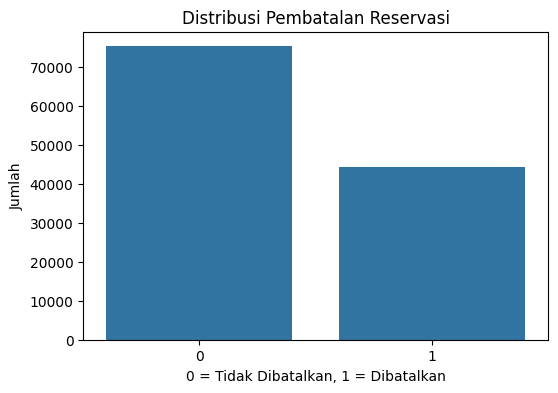

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='is_canceled', data=df)
plt.title("Distribusi Pembatalan Reservasi")
plt.xlabel("0 = Tidak Dibatalkan, 1 = Dibatalkan")
plt.ylabel("Jumlah")
plt.show()


DATA PREPROCESSING

In [8]:
# Hapus kolom yang mengandung informasi masa depan
df_clean = df.drop(['reservation_status', 'reservation_status_date'], axis=1)

# Isi missing value
df_clean['children'] = df_clean['children'].fillna(0)
df_clean['agent'] = df_clean['agent'].fillna(0)
df_clean['company'] = df_clean['company'].fillna(0)

X = df_clean.drop('is_canceled', axis=1)
y = df_clean['is_canceled']

#Membuat Pipeline Preprocessing (Encoding + Scaling)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

cat_features = X.select_dtypes(include='object').columns
num_features = X.select_dtypes(exclude='object').columns

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])


In [9]:
#Split Data Train dan Test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [10]:
#Menangani Imbalance dengan SMOTE
from imblearn.over_sampling import SMOTE

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_prep, y_train)

print("Sebelum SMOTE:", y_train.value_counts())
print("Sesudah SMOTE:", pd.Series(y_train_balanced).value_counts())

Sebelum SMOTE: is_canceled
0    60133
1    35379
Name: count, dtype: int64
Sesudah SMOTE: is_canceled
0    60133
1    60133
Name: count, dtype: int64


EXPLORATORY DATA ANALYSIS (EDA)

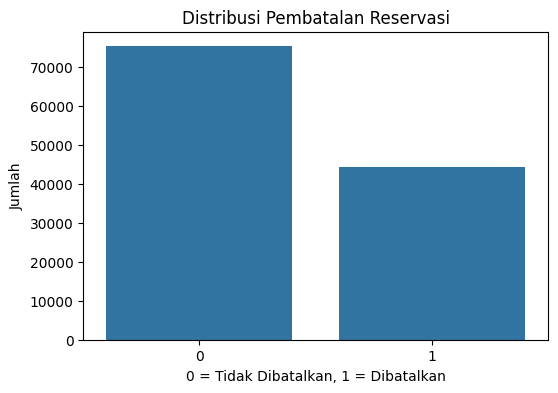

In [11]:
#Distribusi Status Pembatalan
plt.figure(figsize=(6,4))
sns.countplot(x='is_canceled', data=df_clean)
plt.title("Distribusi Pembatalan Reservasi")
plt.xlabel("0 = Tidak Dibatalkan, 1 = Dibatalkan")
plt.ylabel("Jumlah")
plt.show()


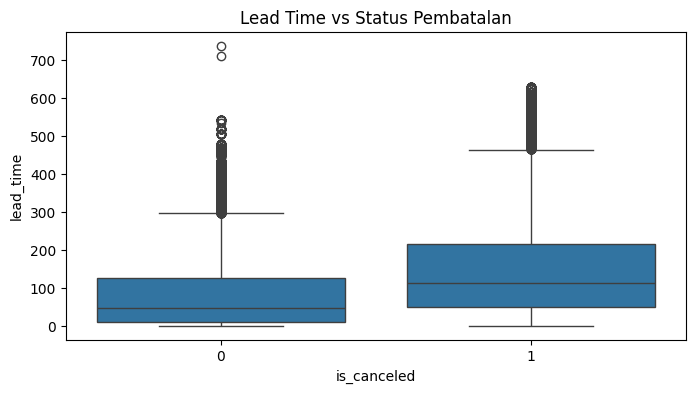

In [12]:
#Lead Time terhadap Pembatalan
plt.figure(figsize=(8,4))
sns.boxplot(x='is_canceled', y='lead_time', data=df_clean)
plt.title("Lead Time vs Status Pembatalan")
plt.show()


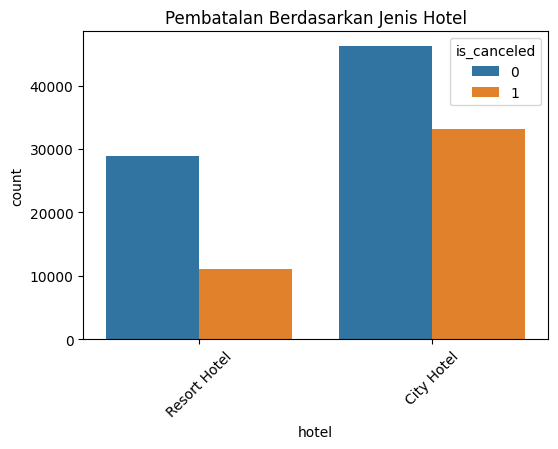

In [13]:
#Jenis Hotel vs Pembatalan
plt.figure(figsize=(6,4))
sns.countplot(x='hotel', hue='is_canceled', data=df_clean)
plt.title("Pembatalan Berdasarkan Jenis Hotel")
plt.xticks(rotation=45)
plt.show()

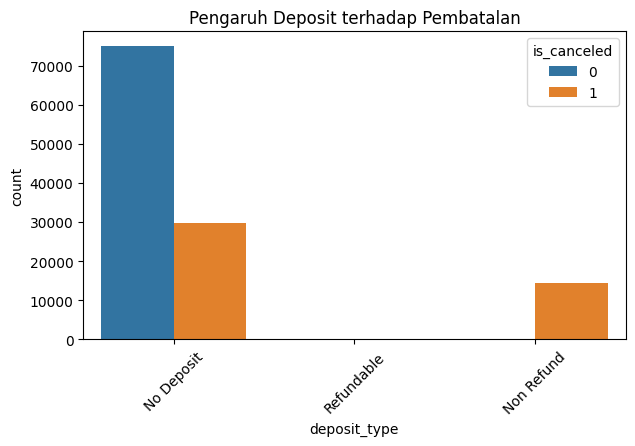

In [14]:
#Tipe Deposit vs Pembatalan
plt.figure(figsize=(7,4))
sns.countplot(x='deposit_type', hue='is_canceled', data=df_clean)
plt.title("Pengaruh Deposit terhadap Pembatalan")
plt.xticks(rotation=45)
plt.show()


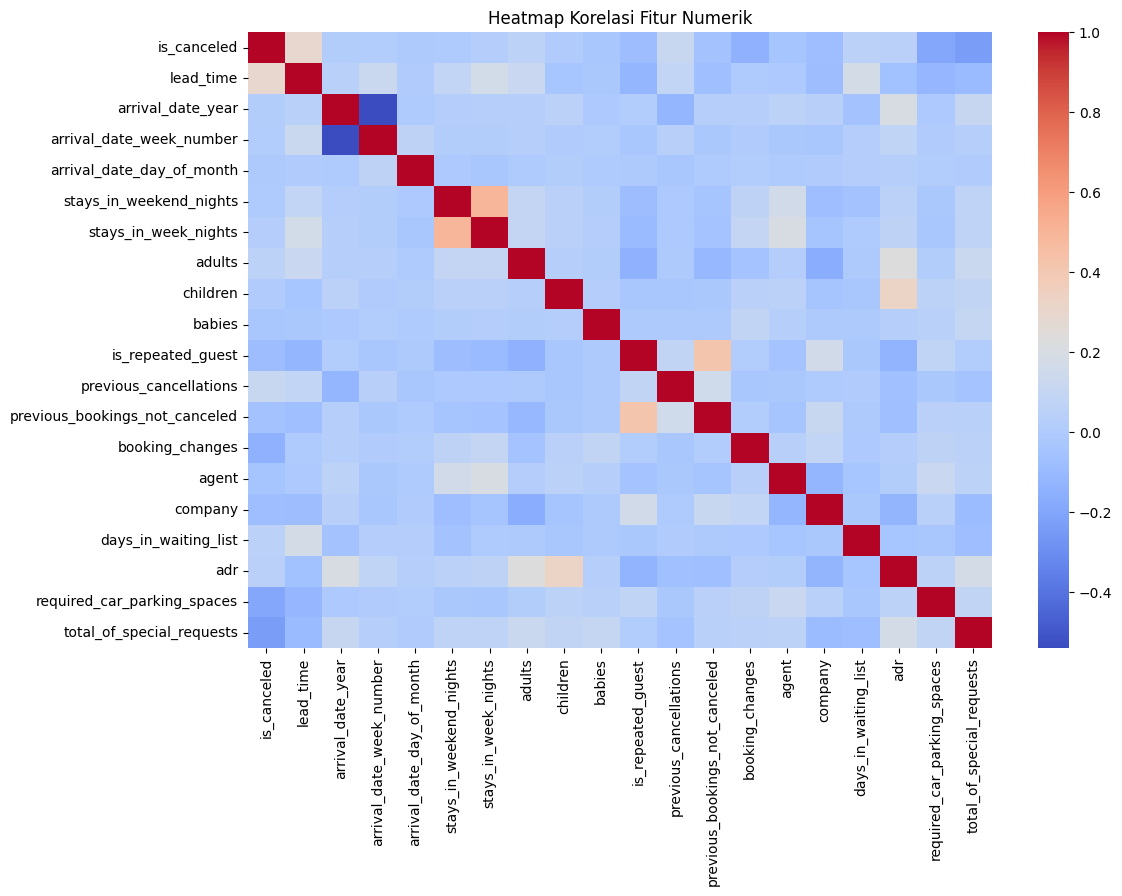

In [15]:
#Heatmap Korelasi Fitur Numerik
numerical_df = df_clean.select_dtypes(include=['int64','float64'])

plt.figure(figsize=(12,8))
sns.heatmap(numerical_df.corr(), cmap='coolwarm', annot=False)
plt.title("Heatmap Korelasi Fitur Numerik")
plt.show()


FEATURE SELECTION

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf_fs = RandomForestClassifier(
    n_estimators=50,      # kurangi jumlah pohon
    max_depth=15,        # batasi kedalaman
    n_jobs=-1,           # pakai semua core CPU
    random_state=42
)

# Ambil sebagian data saja agar cepat
X_fs = X_train_balanced[:20000]
y_fs = y_train_balanced[:20000]

rf_fs.fit(X_fs, y_fs)

importances = rf_fs.feature_importances_
feature_names = preprocessor.get_feature_names_out()

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df.head(10)


,Feature,Importance
247,cat__deposit_type_Non Refund,0.124328
246,cat__deposit_type_No Deposit,0.115523
0,num__lead_time,0.079573
168,cat__country_PRT,0.076258
18,num__total_of_special_requests,0.052624
10,num__previous_cancellations,0.049238
13,num__agent,0.039128
217,cat__market_segment_Online TA,0.033533
16,num__adr,0.031053
17,num__required_car_parking_spaces,0.026113


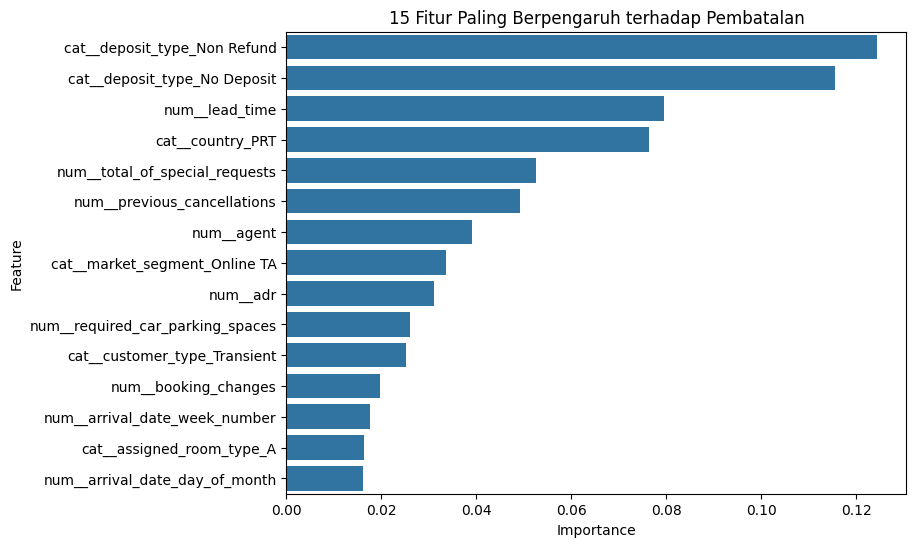

In [17]:
#Visualisasi Top 15 Fitur Terpenting
top_features = feature_importance_df.head(15)

plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title("15 Fitur Paling Berpengaruh terhadap Pembatalan")
plt.show()


MODELING

In [18]:
#Membangun Model Logistic Regression (Baseline)
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_balanced, y_train_balanced)

y_pred_logreg = logreg.predict(X_test_prep)


In [19]:
#Membangun Model Random Forest (Model Utama)
rf_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=15,
    min_samples_leaf=20,
    n_jobs=-1,
    random_state=42
)


rf_model.fit(X_train_balanced, y_train_balanced)

y_pred_rf = rf_model.predict(X_test_prep)
y_proba_rf = rf_model.predict_proba(X_test_prep)


MODEL EVALUATION

In [20]:
#Confusion Matrix & Classification Report
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

print("=== Evaluasi Logistic Regression ===")
print(classification_report(y_test, y_pred_logreg))

print("=== Evaluasi Random Forest ===")
print(classification_report(y_test, y_pred_rf))


=== Evaluasi Logistic Regression ===
              precision    recall  f1-score   support

           0       0.86      0.83      0.85     15033
           1       0.73      0.78      0.75      8845

    accuracy                           0.81     23878
   macro avg       0.80      0.80      0.80     23878
weighted avg       0.81      0.81      0.81     23878

=== Evaluasi Random Forest ===
              precision    recall  f1-score   support

           0       0.88      0.89      0.88     15033
           1       0.81      0.79      0.80      8845

    accuracy                           0.85     23878
   macro avg       0.84      0.84      0.84     23878
weighted avg       0.85      0.85      0.85     23878



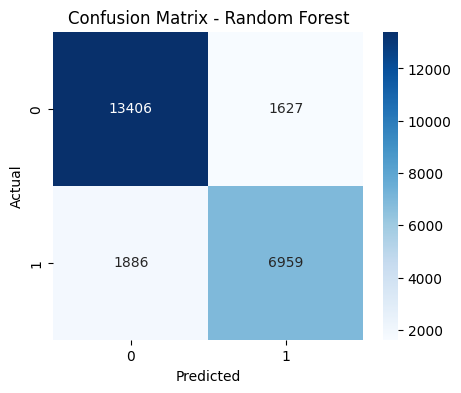

In [21]:
#Confusion Matrix Random Forest
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


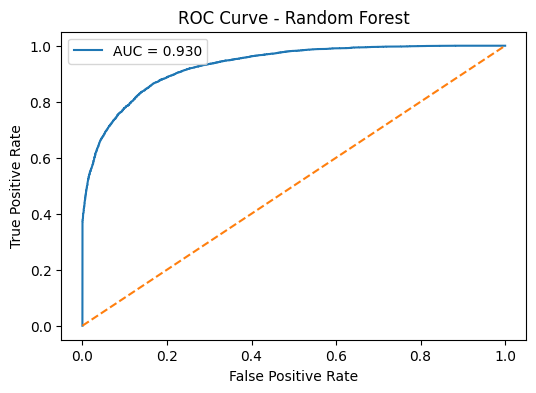

ROC-AUC Score: 0.9304231839378654


In [22]:
#ROC Curve & AUC
fpr, tpr, _ = roc_curve(y_test, y_proba_rf[:,1])
roc_auc = roc_auc_score(y_test, y_proba_rf[:,1])

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()

print("ROC-AUC Score:", roc_auc)


SAVE MODEL

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import joblib

final_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        min_samples_leaf=10,
        n_jobs=-1,
        random_state=42
    ))
])

final_pipeline.fit(X_train, y_train)

joblib.dump(final_pipeline, "hotel_cancellation_model.pkl")
print("Model berhasil disimpan.")


Model berhasil disimpan.


SIMULASI PREDIKSI BOOKING

In [24]:
#Load Model
model = joblib.load("hotel_cancellation_model.pkl")

#Input Manual (Real Case Simulation)
new_booking = pd.DataFrame({
    'hotel': ['City Hotel'],
    'lead_time': [120],
    'arrival_date_year': [2017],
    'arrival_date_month': ['July'],
    'arrival_date_week_number': [27],
    'arrival_date_day_of_month': [15],
    'stays_in_weekend_nights': [1],
    'stays_in_week_nights': [3],
    'adults': [2],
    'children': [0],
    'babies': [0],
    'meal': ['BB'],
    'market_segment': ['Online TA'],
    'distribution_channel': ['TA/TO'],
    'is_repeated_guest': [0],
    'previous_cancellations': [1],
    'previous_bookings_not_canceled': [0],
    'reserved_room_type': ['A'],
    'assigned_room_type': ['A'],
    'booking_changes': [0],
    'deposit_type': ['No Deposit'],
    'agent': [0],
    'company': [0],
    'days_in_waiting_list': [0],
    'customer_type': ['Transient'],
    'adr': [95.0],
    'required_car_parking_spaces': [0],
    'total_of_special_requests': [0]
})


In [29]:
# Ambil satu baris dari data asli sebagai template struktur
sample_template = X_train.iloc[[0]].copy()

# Ubah nilainya sesuai skenario booking baru
sample_template['hotel'] = 'City Hotel'
sample_template['lead_time'] = 200 # satuan hari
sample_template['adr'] = 95.0 # rata-rata harga hotel permalam dalam bentuk euro
sample_template['deposit_type'] = 'No Deposit'
sample_template['previous_cancellations'] = 1
sample_template['total_of_special_requests'] = 0

# Prediksi
pred = model.predict(sample_template)
proba = model.predict_proba(sample_template)

print("=== HASIL SIMULASI PREDIKSI ===")
print("Prediksi:", "DIBATALKAN" if pred[0]==1 else "TIDAK DIBATALKAN")
print("Probabilitas Dibatalkan:", round(proba[0][1]*100,2), "%")
print("Probabilitas Tidak Dibatalkan:", round(proba[0][0]*100,2), "%")

=== HASIL SIMULASI PREDIKSI ===
Prediksi: TIDAK DIBATALKAN
Probabilitas Dibatalkan: 49.17 %
Probabilitas Tidak Dibatalkan: 50.83 %


DOWNLOAD MODEL DALAM BENTUK FILE PKL

In [26]:
from google.colab import files

files.download("hotel_cancellation_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>